In [34]:
import base64
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.tools as tls
from collections import Counter
from scipy.misc import imread
import seaborn as sns
import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
from matplotlib import pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)

color = sns.color_palette()

pd.options.mode.chained_assignment = None

In [35]:
# Read training data with Pandas
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
print("Number of rows in train dataset : ",df_train.shape[0])
print("Number of rows in test dataset : ",df_test.shape[0])

Number of rows in train dataset :  19579
Number of rows in test dataset :  8392


Let's explore the three authors: Edgar Allan Poe (EAP), HP Lovecraft (HPL), and Mary Wollstonecraft Shelley (MWS).

In [36]:
df_train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [37]:
df_train.describe()

,id,text,author
count,19579,19579,19579
unique,19579,19579,3
top,id12441,The inhabitants of that street impressed me pe...,EAP
freq,1,1,7900


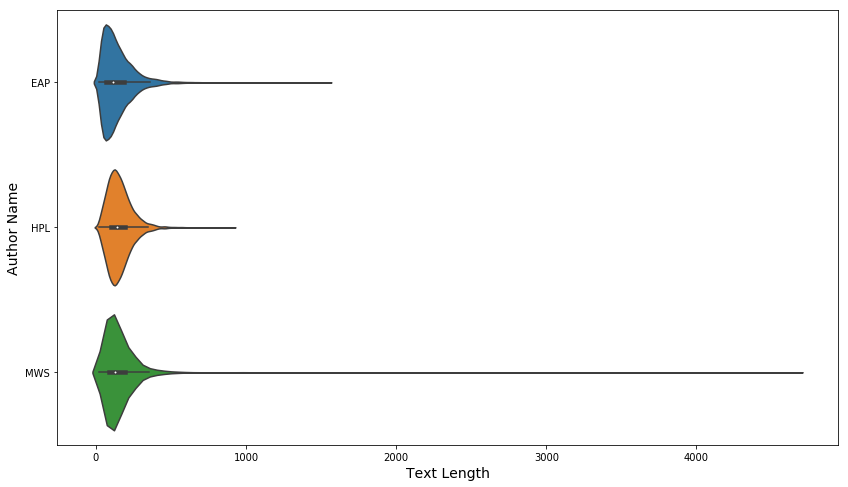

In [38]:
df_train['text_len']=df_train["text"].apply(lambda x: len(str(x)))

plt.figure(figsize=(14,8))
sns.violinplot(x="text_len", y="author", data=df_train, scale="width")
plt.ylabel('Author Name', fontsize=14)
plt.xlabel('Text Length', fontsize=14)
plt.show()

There are some really long blocks of texts for Mary.

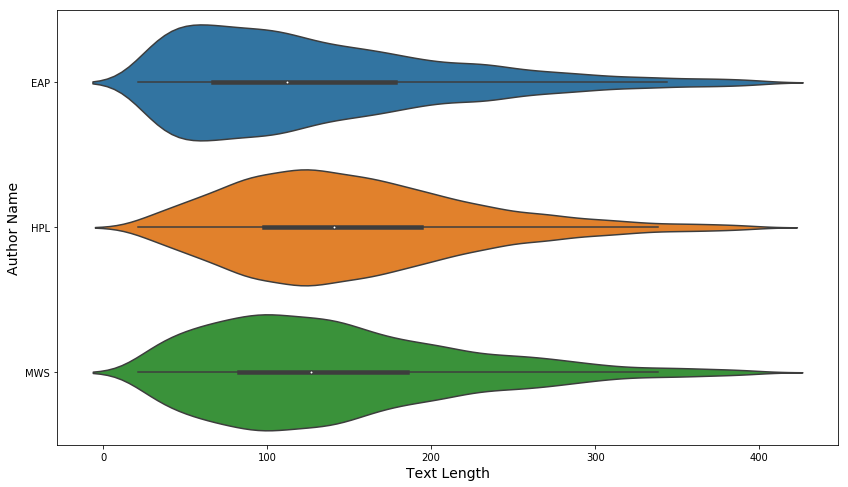

In [39]:
plt.figure(figsize=(14,8))
sns.violinplot(x="text_len", y="author", data=df_train[df_train["text_len"] < 400], scale="width")
plt.ylabel('Author Name', fontsize=14)
plt.xlabel('Text Length', fontsize=14)
plt.show()

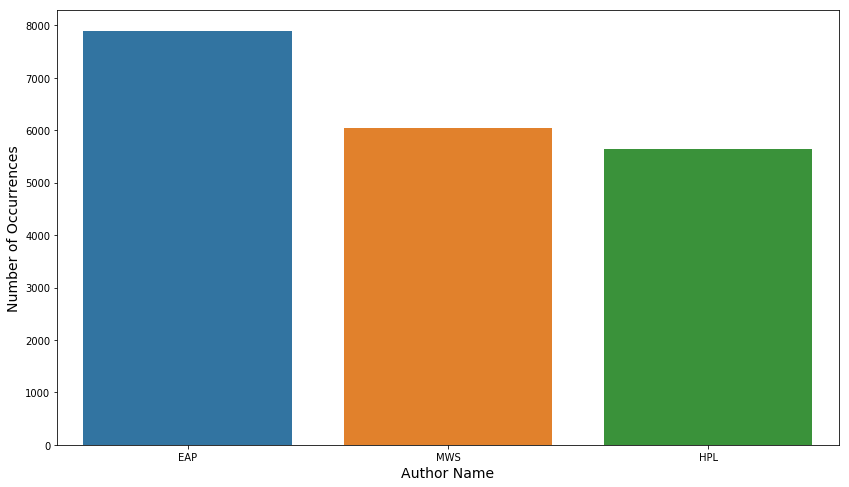

In [40]:
auth_cnt = df_train['author'].value_counts()
auth_cnt.values

plt.figure(figsize=(14,8))
sns.barplot(auth_cnt.index, auth_cnt.values)
plt.ylabel('Number of Occurrences', fontsize=14)
plt.xlabel('Author Name', fontsize=14)
plt.show()

## Removing stopwords

In [41]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

# Needed to get rid of punctuation
tokenizer = RegexpTokenizer(r'\w+')
# Searching a set is much faster than searching a list
eng_stopwords = set(stopwords.words("english"))

def cleanup_spooky_text( spooky_text ):
    #convert to lower case, and split into individual words
    spooky_words = tokenizer.tokenize(spooky_text.lower())
    #remove stop words
    meaningful_spooky_words = [w for w in spooky_words if not w in eng_stopwords]   
    # join the words back into one string separated by space
    return( " ".join(meaningful_spooky_words))

print(eng_stopwords)

{'against', 'having', 'up', 'he', 'for', 'off', 'until', 'between', 'she', 'are', 'should', 'few', 'over', 'shouldn', 'were', "don't", 'yourselves', 'had', 'during', 'very', 'his', "should've", "isn't", 'other', 'himself', 'why', 'they', 'been', 'do', 'whom', 'own', 'him', 'on', 'because', 'a', 'not', 'just', 'wasn', 'wouldn', 'did', 'some', "haven't", 'then', 'below', 'can', 'as', 'from', 'the', 'further', 'couldn', "hadn't", "weren't", 'me', 'herself', 'where', "shouldn't", "aren't", 'under', 'will', 'yours', 'its', 'have', 'your', 'most', 'themselves', "shan't", 'same', 'don', 'ourselves', 'about', 'won', 'itself', 'i', 'which', 'but', 'o', 'yourself', 'was', 'more', "you're", 'when', 'such', "wasn't", 'weren', "you've", "mustn't", 'theirs', 'these', 'by', 'after', 'ours', 'doing', 'there', 're', 'y', 'haven', 'shan', 'needn', 'ma', 'our', 'my', 'above', "you'd", 'once', 'is', 'any', 'than', "that'll", "didn't", "you'll", 'myself', 'be', 'mustn', 'hadn', 'how', 'd', 'while', 'them',

In [42]:
df_train["text"].head()

0    This process, however, afforded me no means of...
1    It never once occurred to me that the fumbling...
2    In his left hand was a gold snuff box, from wh...
3    How lovely is spring As we looked from Windsor...
4    Finding nothing else, not even gold, the Super...
Name: text, dtype: object

In [43]:
df_train["clean_text"] = df_train["text"].apply(lambda x: cleanup_spooky_text(x))

In [44]:
df_train["clean_text"].head()

0    process however afforded means ascertaining di...
1           never occurred fumbling might mere mistake
2    left hand gold snuff box capered hill cutting ...
3    lovely spring looked windsor terrace sixteen f...
4    finding nothing else even gold superintendent ...
Name: clean_text, dtype: object

Let's see the lenght again.

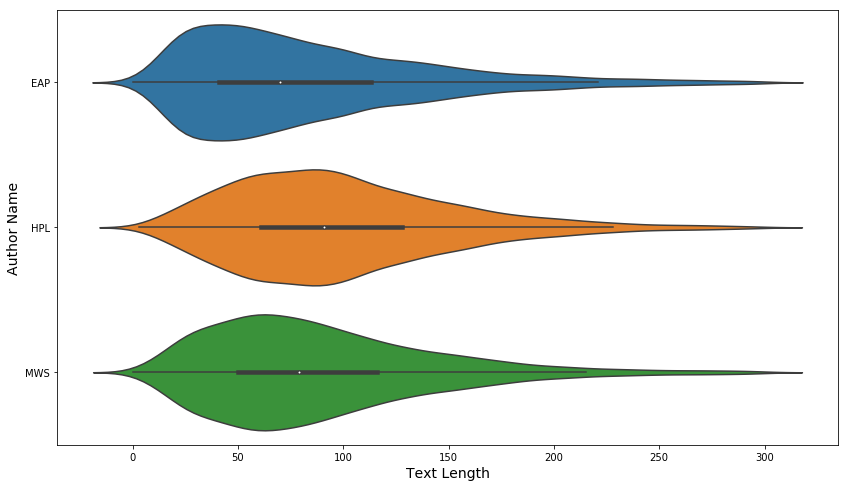

In [46]:
df_train['clean_text_len']=df_train["clean_text"].apply(lambda x: len(str(x)))

plt.figure(figsize=(14,8))
sns.violinplot(x="clean_text_len", y="author", data=df_train[df_train["clean_text_len"] < 300], scale="width")
plt.ylabel('Author Name', fontsize=14)
plt.xlabel('Text Length', fontsize=14)
plt.show()

Let's create 3 lists to store the texts for each author

In [48]:
EAP_text = df_train[df_train.author=="EAP"]["clean_text"].values
HPL_text = df_train[df_train.author=="HPL"]["clean_text"].values
MWS_text = df_train[df_train.author=="MWS"]["clean_text"].values

## WordClouds to visualise the preferred spooky words of each author



In [49]:
from wordcloud import WordCloud

(-0.5, 399.5, 199.5, -0.5)

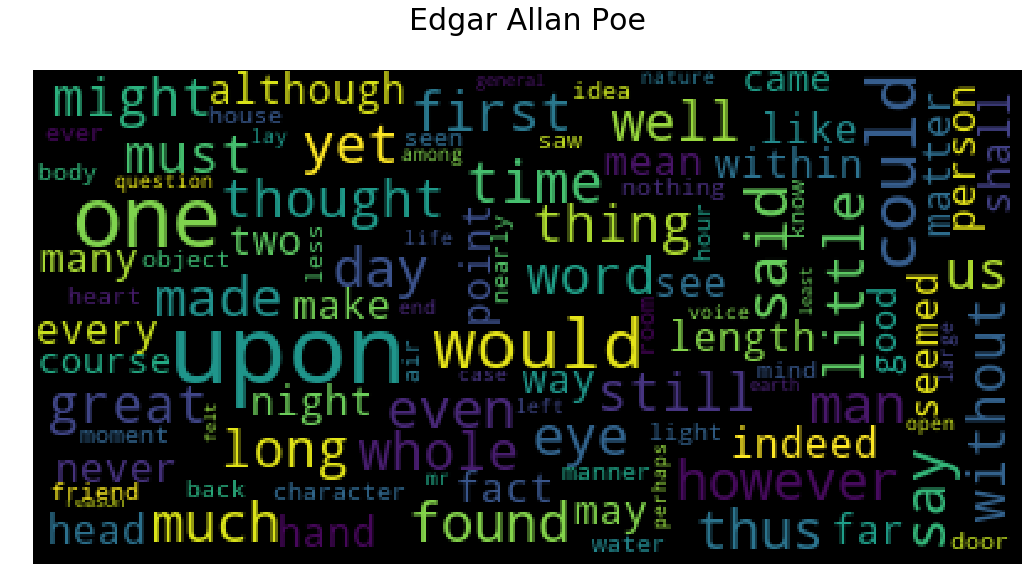

In [50]:
plt.figure(figsize=(20,20))
plt.subplot(211)
wc = WordCloud(background_color="black", max_words=100, 
               stopwords=eng_stopwords, max_font_size= 40)
wc.generate(" ".join(EAP_text))
plt.title("Edgar Allan Poe\n", fontsize=30)
plt.imshow(wc.recolor(colormap= 'viridis', random_state=17))
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

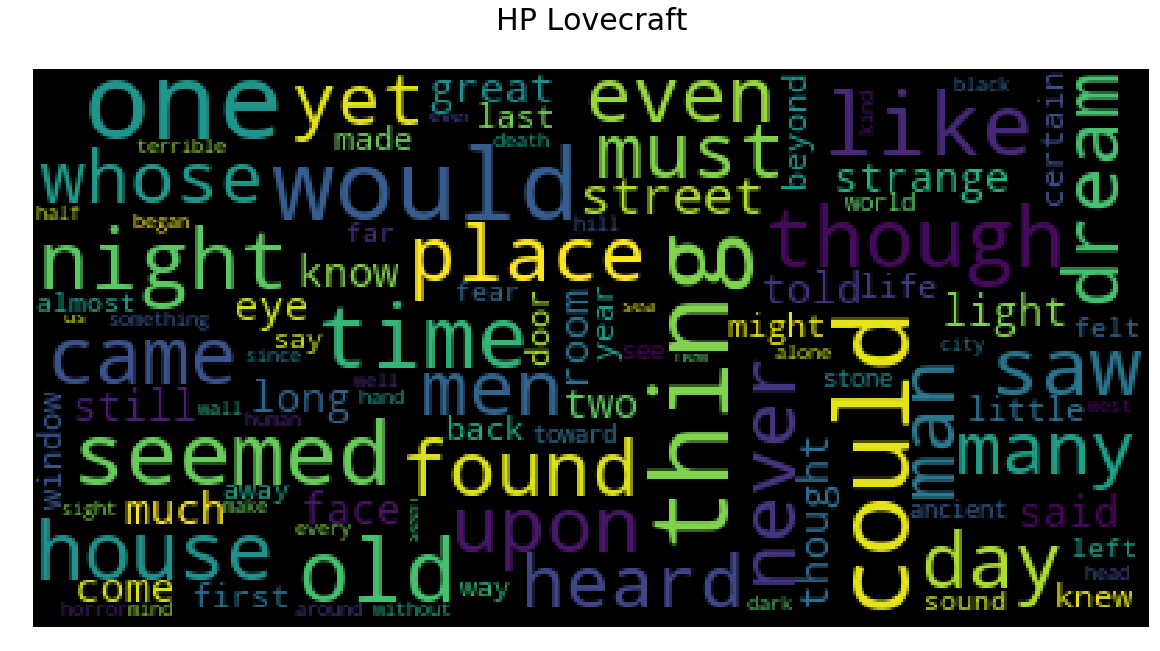

In [52]:
plt.figure(figsize=(20,20))
wc = WordCloud(background_color="black", max_words=100, 
               stopwords=eng_stopwords, max_font_size= 40)
wc.generate(" ".join(HPL_text))
plt.title("HP Lovecraft\n", fontsize=30)
plt.imshow(wc.recolor(colormap= 'viridis', random_state=17))
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

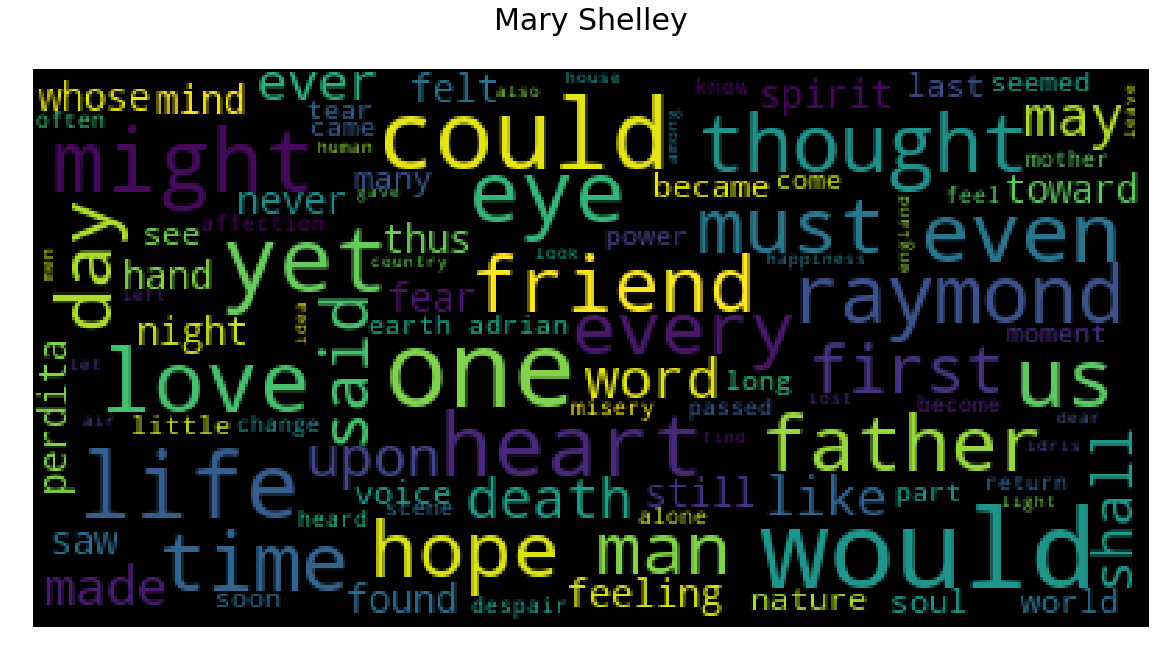

In [54]:
plt.figure(figsize=(20,20))
wc = WordCloud(background_color="black", max_words=100, 
               stopwords=eng_stopwords, max_font_size= 40)
wc.generate(" ".join(MWS_text))
plt.title("Mary Shelley\n", fontsize= 30)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17))
plt.axis('off')

Let's display a plot to show the distribution of number of words from texts for each author

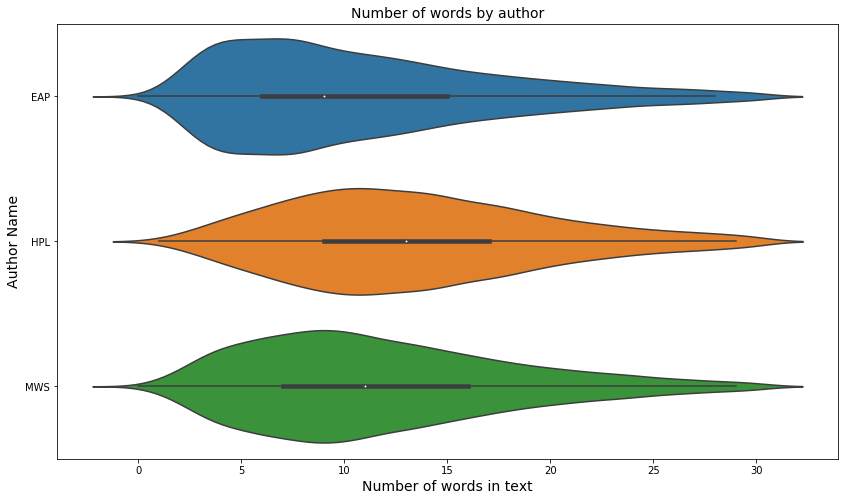

In [55]:
## Number of words in the text ##
df_train["num_words"] = df_train["clean_text"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(14,8))
sns.violinplot(x='num_words', y='author', data=df_train[df_train["num_words"] <= 30])
plt.xlabel('Number of words in text', fontsize=14)
plt.ylabel('Author Name', fontsize=14)
plt.title('Number of words by author', fontsize=14)
plt.show()

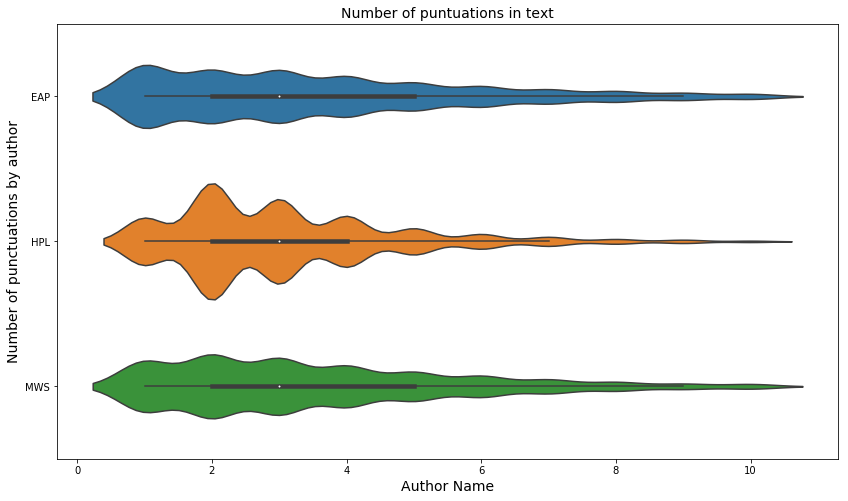

In [56]:
df_train["num_puncts"] = df_train['text'].apply(lambda x: len([c for c in str(x) \
                                                                     if c in string.punctuation]) )
plt.figure(figsize=(14,8))
sns.violinplot(x='num_puncts', y='author', data=df_train[df_train['num_puncts'] <= 10])
plt.xlabel('Author Name', fontsize=14)
plt.ylabel('Number of punctuations by author', fontsize=14)
plt.title('Number of puntuations in text', fontsize=14)
plt.show()

Adding some features:

In [26]:
df_test["clean_text"] = df_test["text"].apply(lambda x: cleanup_spooky_text(x))

## Number of characters in the text
df_train["nb_chars"] = df_train["text"].apply(lambda x: len(str(x)))
df_test["nb_chars"] = df_test["text"].apply(lambda x: len(str(x)))

## Number of words in the text
df_train["nb_words"] = df_train["text"].apply(lambda x: len(str(x).split()))
df_test["nb_words"] = df_test["text"].apply(lambda x: len(str(x).split()))

## Number of relevant words in the text (stop words removed)
df_train["nb_rel_words"] = df_train["clean_text"].apply(lambda x: len(str(x).split()))
df_test["nb_rel_words"] = df_test["clean_text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text (stop words removed)
df_train["nb_uniq_words"] = df_train["clean_text"].apply(lambda x: len(set(str(x).split())))
df_test["nb_uniq_words"] = df_test["clean_text"].apply(lambda x: len(set(str(x).split())))

## Number of stopwords in the text
df_train["nb_stopwords"] = df_train["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
df_test["nb_stopwords"] = df_test["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

## Number of punctuations in the text
df_train["nb_punct"] =df_train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
df_test["nb_punct"] =df_test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )